In [47]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (precision_score, classification_report,
roc_auc_score, confusion_matrix)

In [2]:
df = pd.read_csv('diabetes.csv')
pd.options.display.max_rows = 50
df.head(50)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


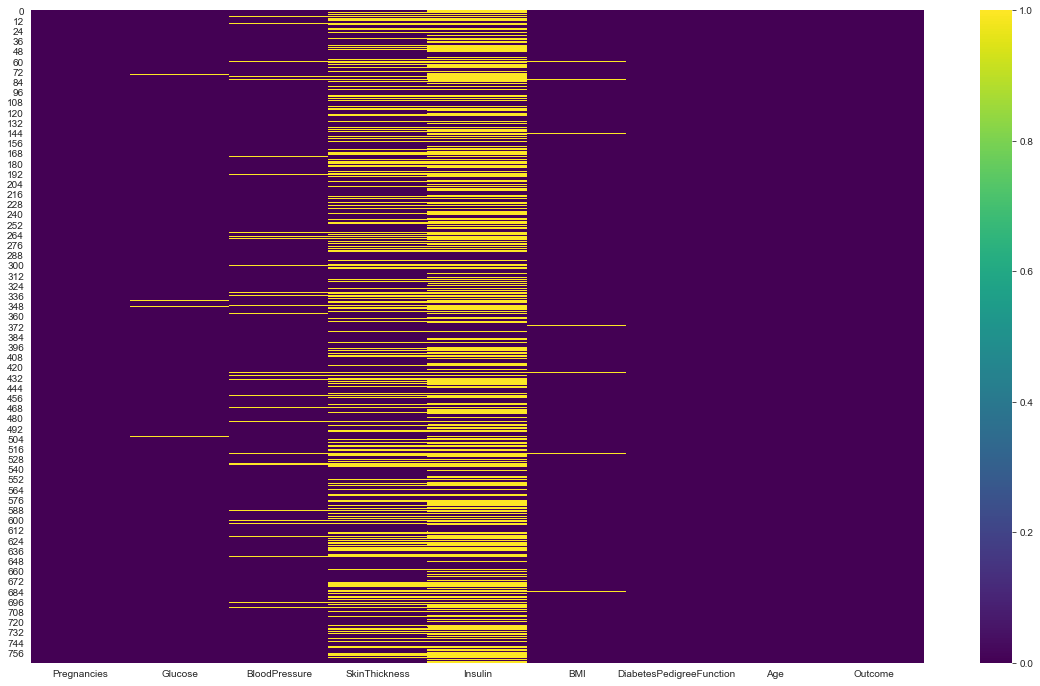

In [3]:
df.iloc[:,1:-1] = df.drop(['Pregnancies','Outcome'], axis=1).replace(to_replace=0, value=np.nan)
plt.figure(figsize=(20,12))
sns.heatmap(df.isna(), cmap='viridis')

In [4]:
df.drop(['Insulin','SkinThickness'], axis=1, inplace=True)
for column in ['Glucose','BloodPressure','BMI']:
    df.loc[df[column].isna(), column] = df[column].median()

df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

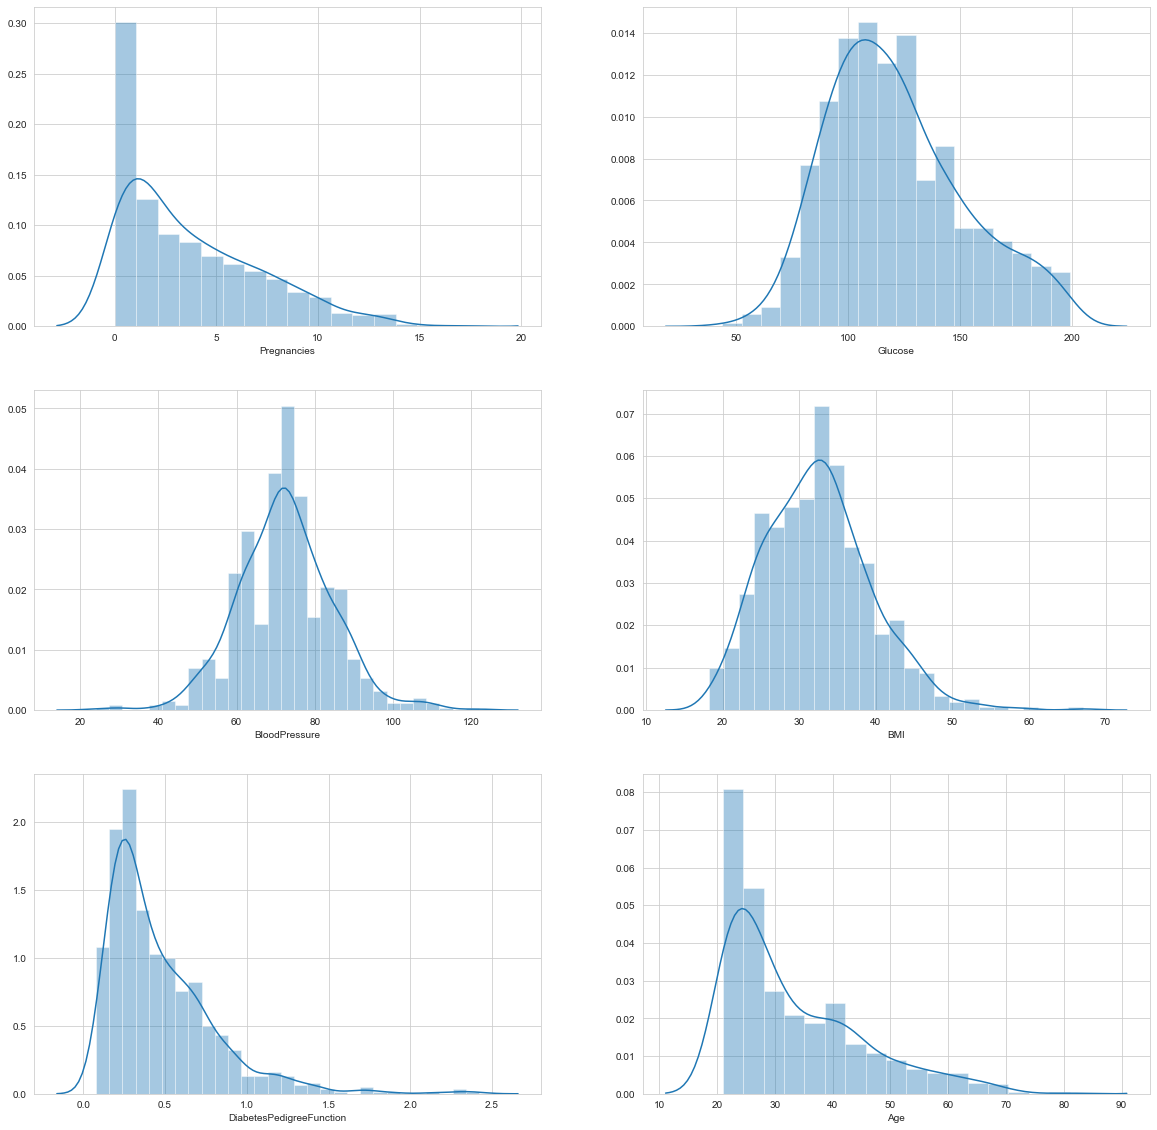

In [5]:
figs, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
sns.distplot(df['Pregnancies'], ax=axes[0,0])
sns.distplot(df['Glucose'], ax=axes[0,1])
sns.distplot(df['BloodPressure'], ax=axes[1,0])
sns.distplot(df['BMI'], ax=axes[1,1])
sns.distplot(df['DiabetesPedigreeFunction'], ax=axes[2,0])
sns.distplot(df['Age'], ax=axes[2,1])

In [6]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

log_reg = LogisticRegression()
dec_tree = DecisionTreeClassifier()
rand_for = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC()
xgb = XGBClassifier()
                                                    
all_models = [log_reg, dec_tree, rand_for, knn, svm, xgb]
models_str = []
for model in all_models:
    models_str.append(model.__class__.__name__)
    
results_df = pd.DataFrame(index=[x.__class__.__name__ for x in all_models])

As these are medical health condition predictions I am gonna optimize precision

In [7]:
test_preds = {}
train_preds = {}
for model in all_models:
    model.fit(X_train, y_train)
    test_preds[model] = model.predict(X_test)
    train_preds[model] = model.predict(X_train)
    
precision = results_df.assign(test_precision=np.nan, train_precision=np.nan)

for model, prediction in test_preds.items():
    precision.loc[model.__class__.__name__, 'test_precision'] = precision_score(y_test, 
                                                                            prediction)
    
for model, prediction in train_preds.items():    
    precision.loc[model.__class__.__name__, 'train_precision'] = precision_score(y_train, 
                                                                            prediction)

precision

,test_precision,train_precision
LogisticRegression,0.732143,0.701863
DecisionTreeClassifier,0.571429,1.000000
RandomForestClassifier,0.727273,1.000000
KNeighborsClassifier,0.666667,0.797688
SVC,0.773585,0.815603
XGBClassifier,0.725806,0.892655


In [8]:
#results are pretty bad, and most models seems to overfitted

In [9]:
parameters = {
    LogisticRegression() : {
        'C' : [0.01,0.1,1,10,100],
        'max_iter' : [100,1000,2500,5000],
        'solver' : ['lbfgs','newton-cg','liblinear'],
        'penalty': ['l1','l2','elasticnet'],
        'random_state': [1]
    },
    DecisionTreeClassifier() : {
        'max_depth': [3, 5, 7, 12],
        'max_features': [2, 3],
        'min_samples_leaf' : [1,2,3,4],
        'min_samples_split': [1,2,3,4],
        'random_state': [1]
    },
    RandomForestClassifier() : {
        'max_depth': [3, 5, 7, 12],
        'max_features': [2, 3],
        'min_samples_leaf' : [1,2,3,4],
        'min_samples_split': [1,2,3,4],
        'n_estimators': [100, 200, 300, 1000],
        'random_state': [1]
    },
    KNeighborsClassifier() : {
        'leaf_size' : list(range(1,10,2)),
        'n_neighbors' : list(range(1,10)),
        'p' : [1,2]
    },
    SVC() : {
        'C': [0.1, 1, 10, 100],  
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf','linear'],
        'random_state': [1]
    },
    XGBClassifier() : {
        'min_child_weight': [1, 5, 10],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'random_state': [1]
        }
              
 }

grid_search = {}
for model, params in parameters.items():
    grid_search[model] =  GridSearchCV(estimator=model, param_grid=params,n_jobs=2,
                               cv=5, scoring='precision', refit=True).fit(X_train, y_train)
    
best_params = {}
for model, params in grid_search.items():
    best_params[model] = params.best_estimator_

In [100]:
tuned_test_preds = {}
tuned_train_preds = {}
for model, params in best_params.items():
    tuned_test_preds[model] = params.predict(X_test)
    tuned_train_preds[model] = params.predict(X_train)
    
tuned_precision = results_df.assign(test_precision=np.nan, train_precision=np.nan)

for model, prediction in tuned_test_preds.items():
    tuned_precision.loc[model.__class__.__name__, 'test_precision'] = precision_score(y_test, 
                                                                            prediction)
    
for model, prediction in tuned_train_preds.items():    
    tuned_precision.loc[model.__class__.__name__, 'train_precision'] = precision_score(y_train, 
                                                                            prediction)

tuned_precision

,test_precision,train_precision
LogisticRegression,0.789474,0.800000
DecisionTreeClassifier,0.666667,0.754386
RandomForestClassifier,0.750000,0.796992
KNeighborsClassifier,0.680851,0.874016
SVC,0.765957,0.764228
XGBClassifier,0.681818,0.973118


In [1]:
fig = plt.figure(figsize=(15,10))
axes = fig.add_axes([0,0,0.8,0.8])

axes.set_title('Precision score', fontdict={'fontsize':20})
axes.set_xticklabels(models_str, fontdict={'fontsize':12})
axes.set_ylabel('precision',fontdict={'fontsize':15})

ax1 = axes.plot(tuned_precision['train_precision'], marker='.', markersize=23, ls='--',
         lw=5, markerfacecolor='red')
ax2 = axes.plot(tuned_precision['test_precision'], marker='h',markersize=17, ls='-.',
         lw=5, markerfacecolor='red')
#plt.legend(handles=['ax1', 'ax2'])

legend = axes.legend(['train precision','test precision'], prop={'size': 20})
frame = legend.get_frame()
frame.set_color('yellow')
frame.set_edgecolor('red')

axes.set_xlabel('model')
axes.set_ylabel('precision')

for a, b in zip(models_str, tuned_precision['test_precision'].round(2)): 
    plt.text(a, b, str(b), fontdict={'fontsize':18, 'color':'green','weight':'bold'})

for a, b in zip(models_str, tuned_precision['train_precision'].round(2)): 
    plt.text(a, b, str(b), fontdict={'fontsize':18,'color':'green','weight':'bold'})

NameError: name 'plt' is not defined

In [115]:
#LogisticReggression provides best results and least overfit
print(classification_report(y_test, list(tuned_test_preds.values())[0]),'\n',
      confusion_matrix(y_test, list(tuned_test_preds.values())[0]))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       123
           1       0.79      0.43      0.56        69

    accuracy                           0.76       192
   macro avg       0.77      0.68      0.70       192
weighted avg       0.76      0.76      0.73       192
 
 [[115   8]
 [ 39  30]]


In [104]:
roc_auc_results = results_df.assign(test_roc_auc=np.nan, train_roc_auc=np.nan)

for model, prediction in tuned_test_preds.items():
    roc_auc_results.loc[model.__class__.__name__, 'test_roc_auc'] = roc_auc_score(y_test, 
                                                                            prediction)
    
for model, prediction in tuned_train_preds.items():    
    roc_auc_results.loc[model.__class__.__name__, 'train_roc_auc'] = roc_auc_score(y_train, 
                                                                            prediction)


roc_auc_results

,test_roc_auc,train_roc_auc
LogisticRegression,0.684871,0.648308
DecisionTreeClassifier,0.708554,0.768418
RandomForestClassifier,0.729763,0.730523
KNeighborsClassifier,0.670908,0.757674
SVC,0.716154,0.697719
XGBClassifier,0.740721,0.948143


logistic regression gives best precision, random forest gives best roc_auc score